## Import Libraries

In [4]:
# Base libraries
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
from tqdm import tnrange
from scipy.special import erf
import pickle
import itertools

from SALib.sample import saltelli
from SALib.analyze import sobol

# Personal libraries
import henon_map as hm

# Matplotlib Settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['savefig.dpi'] = 300

## Setup

In [6]:
epsilons = [16.0]#, 16.0, 32.0]

min_turns = 10 ** 1
max_turns = 10 ** 3
n_turn_samples = 100

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = 0.01

baseline_samples = 129
baseline_total_samples = baseline_samples ** 3

other_samples = np.array([9, 17, 33])

### Save setup

In [3]:
with open("setup.pkl", 'wb') as f:
    pickle.dump((epsilons, min_turns, max_turns, n_turn_samples, turn_sampling, d_r, baseline_samples, baseline_total_samples, other_samples), f)

### Load setup

In [4]:
with open("setup.pkl", "rb") as f:
    epsilons, min_turns, max_turns, n_turn_samples, turn_sampling, d_r, baseline_samples, baseline_total_samples, other_samples = pickle.load(f)

## Baseline

In [5]:
data_b = {}
DA_b = {}
error_b = {}

alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

In [6]:
for epsilon in tqdm(epsilons, desc="Baseline"):
    
    # Data generation
    henon_engine = hm.radial_scan.generate_instance(d_r, alpha_flat, theta1_flat, theta2_flat, epsilon)
    radiuses = henon_engine.compute(turn_sampling)
    radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))
    data_b[epsilon] = radiuses

    # Computing DA
    DA = []
    error_list = []
    mod_radiuses = radiuses.copy()
    mod_radiuses = np.power(radiuses, 4)
    
    mod_radiuses1 = integrate.romb(mod_radiuses, dx=d_theta1, axis=1)
    error_radiuses1 = np.absolute(
        (mod_radiuses1 - integrate.romb(mod_radiuses[:,::2,:], dx=d_theta1 * 2, axis=1)) / mod_radiuses1
    )
    error_radiuses1 = np.average(error_radiuses1, axis=1)
        
    mod_radiuses2 = integrate.romb(mod_radiuses1, dx=d_theta2, axis=1)
    error_radiuses2 = np.absolute(
        (mod_radiuses2 - integrate.romb(mod_radiuses1[:,::2], dx=d_theta2 * 2, axis=1)) / mod_radiuses2
    )
    error_radiuses2 += error_radiuses1
    error_radiuses2 = np.average(error_radiuses2, axis=0)
        
    mod_radiuses3 = integrate.romb(mod_radiuses2, dx=d_preliminar_alpha, axis=0)
    error_radiuses3 = np.absolute(
        (mod_radiuses3 - integrate.romb(mod_radiuses2[::2], dx=d_preliminar_alpha * 2, axis=0)) / mod_radiuses3
    )
    error_radiuses3 += error_radiuses2

    error_raw = mod_radiuses3/ (2 * 2 * 2 * np.pi * np.pi) * error_radiuses3
    error = 0.25 * np.power(mod_radiuses3 / (2 * 2 * 2 * np.pi * np.pi), -3/4) * error_raw

    for i in range(len(turn_sampling)):
        DA.append(
            np.power(
                mod_radiuses3[i] / (2 * 2 * 2 * np.pi * np.pi),
                1/4
            )
        )
        error_list.append(error[i])
    DA_b[epsilon] = np.asarray(DA)
    error_b[epsilon] = np.asarray(error_list)

### Saving Data

In [7]:
with open("data/raw_data_b.pkl", 'wb') as f:
    pickle.dump(data_b, f)
    
with open("data/DA_b.pkl", 'wb') as f:
    pickle.dump(DA_b, f)
    
with open("data/error_b.pkl", 'wb') as f:
    pickle.dump(error_b, f)

### Loading Data

In [8]:
with open("data/raw_data_b.pkl", 'rb') as f:
    data_b = pickle.load(f)
    
with open("data/DA_b.pkl", 'rb') as f:
    DA_b = pickle.load(f)
    
with open("data/error_b.pkl", 'rb') as f:
    error_b = pickle.load(f)

## Standard Integral

In [9]:
DA_1 = {}
error_1 = {}
for epsilon in tqdm(epsilons, desc="Standard Integral"):
    base_radiuses = data_b[epsilon]
    
    for i in [2, 4, 8, 16, 32]:
        radiuses = base_radiuses[::i, ::i, ::i]
        DA = []
        error_list = []
        mod_radiuses = radiuses.copy()
        mod_radiuses = np.power(radiuses, 4)
        
        mod_radiuses1 = integrate.romb(mod_radiuses, dx=d_theta1 * i, axis=1)
        error_radiuses1 = np.absolute(
            (mod_radiuses1 - integrate.romb(mod_radiuses[:,::2,:], dx=d_theta1 * i * 2, axis=1)) / mod_radiuses1
        )
        error_radiuses1 = np.average(error_radiuses1, axis=1)
        
        mod_radiuses2 = integrate.romb(mod_radiuses1, dx=d_theta2 * i, axis=1)
        error_radiuses2 = np.absolute(
            (mod_radiuses2 - integrate.romb(mod_radiuses1[:,::2], dx=d_theta2 * i * 2, axis=1)) / mod_radiuses2
        )
        error_radiuses2 += error_radiuses1
        error_radiuses2 = np.average(error_radiuses2, axis=0)
        
        mod_radiuses3 = integrate.romb(mod_radiuses2, dx=d_preliminar_alpha * i, axis=0)
        error_radiuses3 = np.absolute(
            (mod_radiuses3 - integrate.romb(mod_radiuses2[::2], dx=d_preliminar_alpha * i * 2, axis=0)) / mod_radiuses3
        )
        error_radiuses3 += error_radiuses2
        
        error_raw = mod_radiuses3/ (2 * 2 * 2 * np.pi * np.pi) * error_radiuses3
        error = 0.25 * np.power(mod_radiuses3 / (2 * 2 * 2 * np.pi * np.pi), -3/4) * error_raw

        for j in range(len(turn_sampling)):
            DA.append(
                np.power(
                    mod_radiuses3[j] / (2 * 2 * 2 * np.pi * np.pi),
                    1/4
                )
            )
            error_list.append(error[j])
        DA_1[(epsilon, radiuses.size)] = np.asarray(DA)
        error_1[(epsilon, radiuses.size)] = np.asarray(error_list)

### Saving Data

In [10]:
with open("data/DA_1.pkl", 'wb') as f:
    pickle.dump(DA_1, f)
    
with open("data/error_1.pkl", 'wb') as f:
    pickle.dump(error_1, f)

### Loading Data

In [11]:
with open("data/DA_1.pkl", 'rb') as f:
    DA_1 = pickle.load(f)
    
with open("data/error_1.pkl", 'rb') as f:
    error_1 = pickle.load(f)

## Radial average

In [20]:
DA_2 = {}

DA = []

n_subdivisions = 5

samples = 4097
alpha_preliminary_values = np.linspace(-1.0, 1.0, samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]

for epsilon in tqdm(epsilons, desc="Radial average"):
    # Extracting the radiuses with theta1 = theta2 = 0.0
    
    preliminar_engine = hm.radial_scan.generate_instance(
        d_r, 
        alpha_values, 
        np.zeros(alpha_values.shape),
        np.zeros(alpha_values.shape),
        epsilon
    )
    all_radiuses = preliminar_engine.compute(turn_sampling)
    
    values = []
    for i in tqdm(range(len(turn_sampling))):
        temp_values = np.array([[]])
        for index, j in enumerate(range(0, samples, 128)):
            stopping = (j + 128 if j != samples - 1 else samples)
            radiuses = all_radiuses[j : stopping, i]

            engine = hm.full_track.generate_instance(
                radiuses,
                alpha_values[j : stopping],
                np.zeros(alpha_values.shape)[j : stopping],
                np.zeros(alpha_values.shape)[j : stopping],
                np.ones(alpha_values.shape, dtype=np.int)[j : stopping] * turn_sampling[i],
                epsilon)

            x, y, px, py = engine.compute()
            temp = engine.accumulate_and_return(n_subdivisions)
            if index == 0:
                temp_values = temp
            else:
                temp_values = np.concatenate((temp_values, temp))
        
        values.append(temp_values)
    
    for jump in [1, 2, 4, 8, 16, 32]:
        DA = []
        for i in range(len(turn_sampling)):
            DA.append(np.power(integrate.romb(values[i][::jump], d_preliminar_alpha * jump) * 0.5, 1/4))
        DA_2[(epsilon, len(values[i][::jump]))] = DA

100%|██████████| 100/100 [04:27<00:00,  2.67s/it]


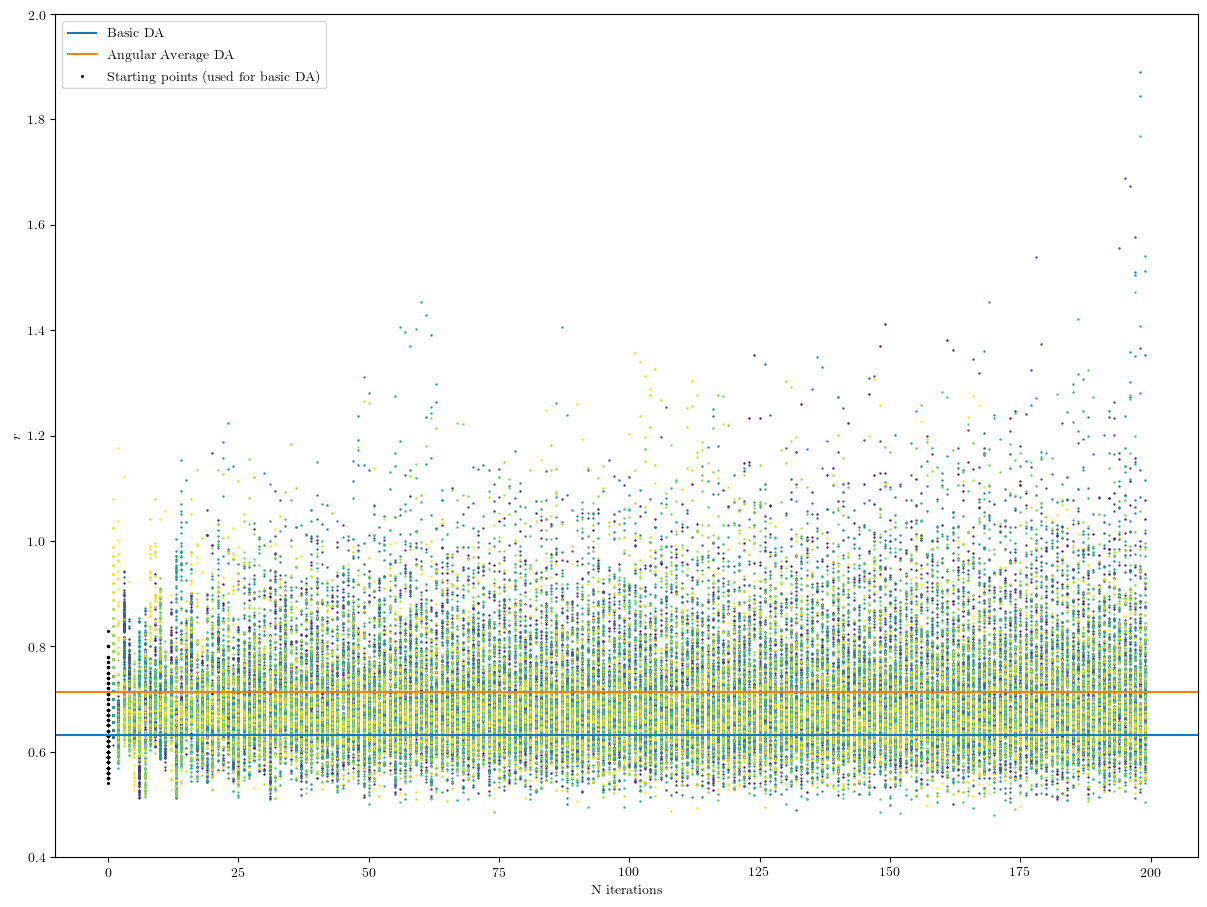

In [13]:
radius, alpha, theta1, theta2 = hm.cartesian_to_polar(x, px, y, py)

plt.figure(figsize=(12, 9))
cmap = matplotlib.cm.get_cmap("viridis")

for i in range(0, radius.shape[1], 16):
    plt.scatter(range(radius.shape[0]), radius[:,i], s=0.5, color=np.asarray([cmap(i/(radius.shape[1]-1))]))

plt.scatter(np.zeros(radius.shape[1]//16+1), radius[0,::16], s=2, marker='x', color='black', label="Starting points (used for basic DA)")
    
plt.axhline(y=np.power(integrate.romb(radius[0,:]**4, d_preliminar_alpha) * 0.5, 1/4), color='C0', label="Basic DA")
plt.axhline(y=DA[-1], color='C1', label="Angular Average DA")
plt.ylim(0.4, 2.0)
plt.legend()
plt.tight_layout()
plt.xlabel("N iterations")
plt.ylabel("$r$")
plt.savefig("img/radial_example_scatter.png", dpi=600)
#plt.xlim(0,200)

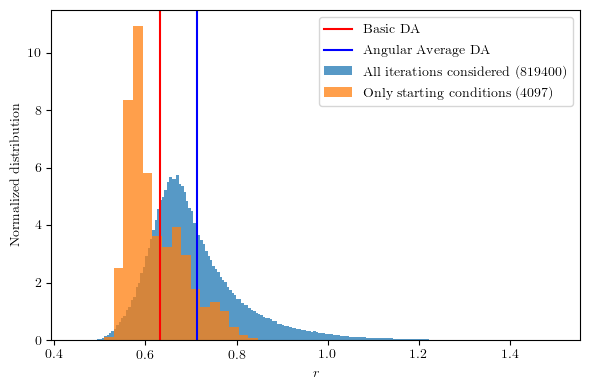

In [14]:
radius, alpha, theta1, theta2 = hm.cartesian_to_polar(x, px, y, py)

plt.hist(radius.flatten(), range=(radius.flatten().min(),1.5), density=True, bins=200, alpha=0.75, label="All iterations considered ({})".format(radius.size))
plt.hist(radius[0], density=True, alpha=0.75, range=(radius.flatten().min(),1.5), bins=50, label="Only starting conditions ({})".format(radius[0].size))

plt.axvline(np.power(integrate.romb(radius[0,:]**4, d_preliminar_alpha) * 0.5, 1/4), color='red', label="Basic DA")
plt.axvline(DA[-1], color='blue', label="Angular Average DA")

plt.xlabel("$r$")
plt.ylabel("Normalized distribution")
plt.legend()

plt.tight_layout()
plt.savefig("img/radial_example.png", dpi=600)

### Saving Data

In [15]:
with open("data/DA_2.pkl", 'wb') as f:
    pickle.dump(DA_2, f)

### Loading Data

In [16]:
with open("data/DA_2.pkl", 'rb') as f:
    DA_2 = pickle.load(f)

## Monte Carlo

In [17]:
mc_max_samples = 33 ** 3
mc_min_samples = 10 ** 2
mc_samples = np.linspace(mc_min_samples, mc_max_samples, 10, dtype=np.int)

problem = {
    'num_vars': 3,
    'names': ['alpha', 'theta1', 'theta2'],
    'bounds': [[-1, 1],
               [0, np.pi * 2],
               [0, np.pi * 2]]
    }
param_values = saltelli.sample(problem, mc_max_samples // 8 + 8)

alpha = np.array([np.arccos(p[0])/2 for p in param_values])
theta1 = np.array([p[1] for p in param_values])
theta2 = np.array([p[2] for p in param_values])

DA_3 = {}
variance_3 = {}
data_3 = {}
for epsilon in tqdm(epsilons, desc="Monte Carlo"):
    # Data generation
    henon_engine = hm.radial_scan.generate_instance(d_r, alpha, theta1, theta2, epsilon)
    radiuses = henon_engine.compute(turn_sampling)
    
    data_3[epsilon] = radiuses

    # Computing DA
    
    for sample in mc_samples:
        average = np.average(np.power(radiuses[:sample], 4), axis=0)
        error = np.std(np.power(radiuses[:sample], 4), axis=0) / np.sqrt(sample)
        DA_3[(epsilon, sample)] = np.power(average, 1/4)
        variance_3[(epsilon, sample)] = 0.25 * np.power(average, -3/4) * error
    

### Saving Data

In [18]:
with open("data/DA_3.pkl", 'wb') as f:
    pickle.dump(DA_3, f)
    
with open("data/variance_3.pkl", 'wb') as f:
    pickle.dump(variance_3, f)

### Loading Data

In [19]:
with open("data/DA_3.pkl", 'rb') as f:
    DA_3 = pickle.load(f)
    
with open("data/variance_3.pkl", 'rb') as f:
    variance_3 = pickle.load(f)

## Stratified Monte Carlo

In [20]:
from stratified_mc import stratified_mc

DA_4 = {}
variance_4 = {}

mc_max_samples = 33 ** 3
mc_samples = np.linspace(0, mc_max_samples, 21, dtype=np.int)[1:]
d_samples = mc_samples[1] - mc_samples[0]
n_sectors = 5

for epsilon in tqdm(epsilons, desc="Stratified Monte Carlo"):
    engine = stratified_mc(n_sectors, mc_max_samples, turn_sampling, d_r, epsilon)
    for iters in mc_samples:
        engine.compute(1, d_samples)
        average, variance = engine.get_result()
        
        DA_4[(epsilon, iters)] = np.power(average, 1/4) 
        variance_4[(epsilon, iters)] = 0.25 * np.power(average, -3/4) * variance 

100%|██████████| 1/1 [08:17<00:00, 497.35s/it]


### Saving Data

In [21]:
with open("data/DA_4.pkl", 'wb') as f:
    pickle.dump(DA_4, f)

with open("data/variance_4.pkl", 'wb') as f:
    pickle.dump(variance_4, f)

### Loading Data

In [22]:
with open("data/DA_4.pkl", 'rb') as f:
    DA_4 = pickle.load(f)
    
with open("data/variance_4.pkl", 'rb') as f:
    variance_4 = pickle.load(f)

## 2D Scan

In [23]:
data_5 = {}
DA_5 = {}
uncertainty_5 = {}

alpha_max_samples = 33 ** 3

alpha_values = np.linspace(0, np.pi * 0.5, alpha_max_samples)

for epsilon in tqdm(epsilons, desc="2D scan"):
    henon_engine = hm.radial_scan.generate_instance(d_r, alpha_values, np.zeros(alpha_values.shape), np.zeros(alpha_values.shape), epsilon)
    radiuses = henon_engine.compute(turn_sampling)
    data_5[(epsilon)] = radiuses

    for i in [1, 2, 4, 8, 16, 32]:
        alpha = alpha_values[::i]
        d_alpha = alpha[1] - alpha[0]
        cutted_radiuses = radiuses[::i]
        value = integrate.simps(cutted_radiuses ** 2, alpha, axis=0)
        less_value = integrate.simps(cutted_radiuses[::2] ** 2, alpha[::2], axis=0)
        uncertainty = np.abs((value - less_value))
        
        DA = np.sqrt(value * 2 / np.pi)
        uncertainty = 0.5 * np.power(value * 2 / np.pi, -0.5) * uncertainty
        DA_5[(epsilon, cutted_radiuses.shape)] = np.asarray(DA)
        uncertainty_5[(epsilon, cutted_radiuses.shape)] = uncertainty 

### Saving Data

In [24]:
with open("data/DA_5.pkl", 'wb') as f:
    pickle.dump(DA_5, f)
    
with open("data/uncertainty_5.pkl", 'wb') as f:
    pickle.dump(uncertainty_5, f)

### Loading Data

In [25]:
with open("data/DA_5.pkl", 'rb') as f:
    DA_5 = pickle.load(f)
    
with open("data/uncertainty_5.pkl", 'rb') as f:
    uncertainty_5 = pickle.load(f)

## Plotting

### Comparisons

In [26]:
import tikzplotlib as tk

cmap = matplotlib.cm.get_cmap('plasma')
epsilon = epsilons[0]

Standard Integral 

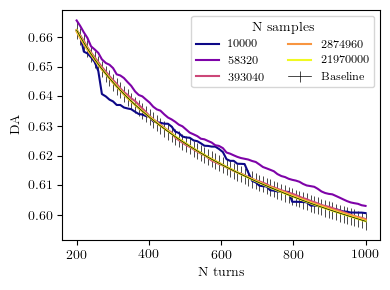

In [27]:
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")
elements = np.linspace(0,1,len(DA_1))
for i, label in enumerate(sorted(DA_1, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.plot(turn_sampling, DA_1[label], c=cmap(elements[i]), label=str(label[1]))
#plt.title("Comparison with Standard Integral")
plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/standard_integral.png", dpi=300)
plt.savefig("img/standard_integral.pgf")
tk.save("img/standard_integral.tex")

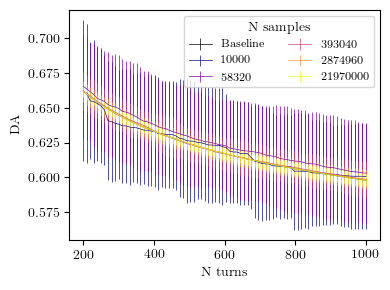

In [28]:
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")
elements = np.linspace(0,1,len(DA_1))
for i, label in enumerate(sorted(DA_1, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.errorbar(turn_sampling, DA_1[label], yerr=error_1[label], c=cmap(elements[i]), linewidth=0.5, elinewidth=0.5, label=str(label[1]))
#plt.title("Comparison with Standard Integral")
plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/standard_integral_error.png", dpi=300)
plt.savefig("img/standard_integral_error.pgf")
tk.save("img/standard_integral_error.tex")

Radial Average

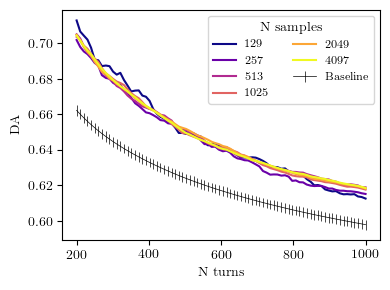

In [29]:
# Radial Average
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")
elements = np.linspace(0,1,len(DA_2))
for i, label in enumerate(sorted(DA_2, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.plot(turn_sampling, np.array(DA_2[label]), c=cmap(elements[i]), label=str(label[1]))
#plt.title("Comparison with Angular Average")
plt.xlabel("N turns")
plt.ylabel("DA")
plt.legend(title="N samples", fontsize="small", ncol=2)
plt.tight_layout()

plt.savefig("img/radial_average.png", dpi=300)
plt.savefig("img/radial_average.pgf")
tk.save("img/radial_average.tex")

Monte Carlo

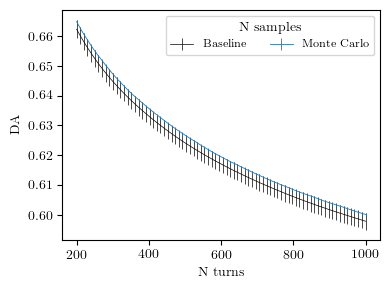

In [30]:
# Monte Carlo
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")

label = sorted(filter(lambda x: x[0] == epsilon, DA_3), key=lambda a: a[1])[-1]
plt.errorbar(turn_sampling, DA_3[label], yerr=variance_3[label], label="Monte Carlo", linewidth=0.6, elinewidth=0.6)

plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/monte_carlo.png", dpi=300)
plt.savefig("img/monte_carlo.pgf")
tk.save("img/monte_carlo.tex")

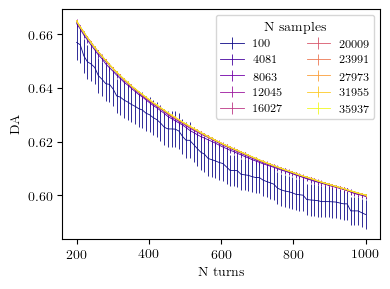

In [38]:
plt.figure(figsize=(4, 3))
elements = np.linspace(0,1,len(DA_3))
for i, label in enumerate(sorted(DA_3, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.errorbar(turn_sampling, DA_3[label], yerr=variance_3[label], c=cmap(elements[i]), label=str(label[1]),linewidth=0.6, elinewidth=0.6)

plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/monte_carlo_evolution.png", dpi=300)
plt.savefig("img/monte_carlo_evolution.pgf")
tk.save("img/monte_carlo_evolution.tex")

Stratified Monte Carlo

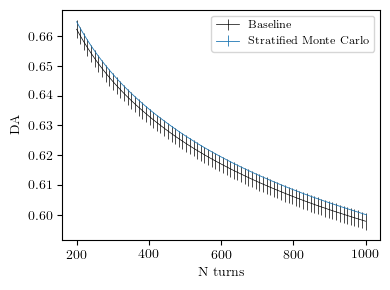

In [32]:
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")

label = sorted(filter(lambda x: x[0] == epsilon, DA_4), key=lambda a: a[1])[-1]

plt.errorbar(turn_sampling, DA_4[label], yerr=variance_4[label], label="Stratified Monte Carlo")

#plt.title("Comparison with Stratified Monte Carlo")
plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(fontsize="small")
plt.tight_layout()

plt.savefig("img/stratified_monte_carlo.png", dpi=300)
plt.savefig("img/stratified_monte_carlo.pgf")
tk.save("img/stratified_monte_carlo.tex")

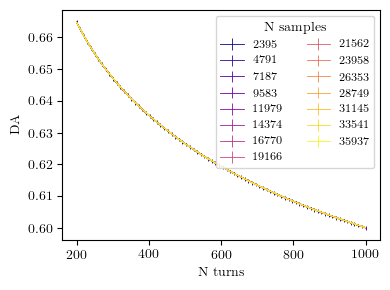

In [40]:
plt.figure(figsize=(4, 3))
elements = np.linspace(0,1,len(DA_4))
for i, label in enumerate(sorted(DA_4, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.errorbar(turn_sampling, DA_4[label], variance_4[label], c=cmap(elements[i]), label=str(label[1]), linewidth=0.6, elinewidth=0.6)

plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/stratified_monte_carlo_evolution.png", dpi=300)
plt.savefig("img/stratified_monte_carlo_evolution.pgf")
tk.save("img/stratified_monte_carlo_evolution.tex")

2D Integral

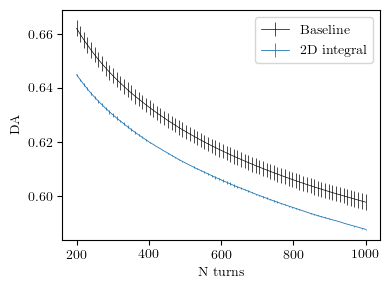

In [36]:
plt.figure(figsize=(4, 3))
plt.errorbar(turn_sampling, DA_b[epsilon], yerr=error_b[epsilon], c="black", linewidth=0.5, elinewidth=0.5, label="Baseline")
elements = np.linspace(0,1,len(DA_5))

label = sorted(filter(lambda x: x[0] == epsilon, DA_5), key=lambda a: a[1])[-1]
plt.errorbar(turn_sampling, DA_5[label], yerr=uncertainty_5[label], label="2D integral", linewidth=0.6, elinewidth=0.6)

#plt.title("Comparison with 2D integral")
plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend()
plt.tight_layout()

plt.savefig("img/2d_integral.png", dpi=300)
plt.savefig("img/2d_integral.pgf")
tk.save("img/2d_integral.png")

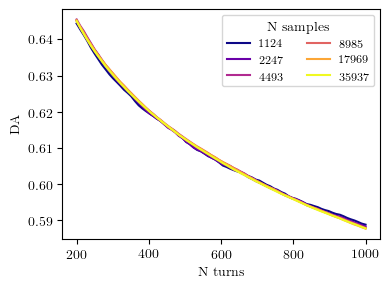

In [37]:
plt.figure(figsize=(4, 3))
elements = np.linspace(0,1,len(DA_5))
for i, label in enumerate(sorted(DA_5, key=lambda a: a[1])):
    if label[0] == epsilon:
        plt.plot(turn_sampling, DA_5[label], c=cmap(elements[i]), label=str(label[1][0]))

plt.xlabel("N turns")
plt.ylabel("DA")

plt.legend(title="N samples", ncol=2, fontsize="small")
plt.tight_layout()

plt.savefig("img/2d_integral_evolution.png", dpi=300)
plt.savefig("img/2d_integral_evolution.pgf")
tk.save("img/2d_integral_evolution.png")